# Use torch.distributions in all the below questions

## Imports

In [94]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import Counter
import ipywidgets as widgets
from ipywidgets import interact

# 1. **Random Variables**

#### Q1. (**Mandatory**)
Write a Python function that simulates rolling two six-sided dice and returns their sum. Use this function to perform 10,000 simulations. Calculate and print:

a) The experimental probability of rolling a sum of 7 <br/>
b) The experimental probability of rolling a sum of 2 or 12<br/>

Compare these experimental probabilities with the theoretical probabilities. What conclusions can you draw about the accuracy of the simulation?

In [95]:
def two_rolling_die():
    # We take sum as our Categorical Random variable
    N = 10000
    probs = [1/36, 2/36, 3/36, 4/36, 5/36, 6/36, 5/36, 4/36, 3/36, 2/36, 1/36]
    data = torch.distributions.Categorical(probs=torch.tensor(probs))
    support = torch.arange(2,13)
    samples = support[data.sample((N,))]
    samples = pd.DataFrame(samples)
    #a) Prob of sum = 7
    print("Experimental")
    print(f"P[sum=7]={samples.value_counts()[7]/N}")
    #b) Prob sum = 2 or 12
    print(f"P[sum=2 or sum=12]={samples.value_counts()[2]/N + samples.value_counts()[12]/N}")
    print("Theoretical")
    print(f"P[sum=2]={probs[7-2]}")
    print(f"P[sum=2 or sum=12]={probs[2-2]+probs[12-2]}")
two_rolling_die()

Experimental
P[sum=7]=0.1642
P[sum=2 or sum=12]=0.0571
Theoretical
P[sum=2]=0.16666666666666666
P[sum=2 or sum=12]=0.05555555555555555


The simulation is fairly accurate (till 2 decimal places). If we would have taken more samples the accuracy would have increased. As samples size approaches infinity, the Experimental value approaches Theoretical value. 

#### Q2. (Optional)
Write a function coin_toss(n) that simulates flipping a coin n times, returning a list of 'H' (Heads) and 'T' (Tails). Then, write a function count_heads(flips) that takes the list of flips and returns the number of heads (this is your random variable, X). Finally, simulate 10 coin tosses and print the outcome of the coin tosses and the number of heads.


In [96]:
def coin_toss(n):
    def ht(x): return "H" if(x==1) else "T" #Function which maps RV to sample space
    p = 0.5
    dist = torch.distributions.Bernoulli(p) 
    trials = [ht(dist.sample()) for i in range(1,n+1)] # Performing the toss n times  
    return trials
def count_heads(trials):
    return pd.Series(trials).value_counts()["H"].item() # Counts the no. of heads
n1 = 10 
trials = coin_toss(n1) 
print("Outcome is: ",trials)
print("No of heads: ",count_heads(trials))

Outcome is:  ['T', 'T', 'T', 'T', 'T', 'T', 'H', 'H', 'T', 'H']
No of heads:  3


#### Q3. (Optional)
#### Coin Flip Simulation and Inverse Mapping Check

Using the `coin_toss(n)` and `count_heads(flips)` functions from Question 1, simulate **n = 4** coin flips.  

Then, given a value **a**, write a function `check_inverse_mapping(flips, a)` that checks whether the number of heads in the simulated coin flips equals **a**. In other words, verify if:  

$$
X(\xi) = a
$$

where:  
- **$X$** represents the function that counts the number of heads in the sequence.  
- **$\xi$** is the outcome of the 4 coin flips.  

The function should print whether **$X(\xi) = a$** is **True or False**.  
Finally, test the function with **a = 2**.  


In [97]:
def coin_toss(n):
    def ht(x): return "H" if(x==1) else "T"
    p = 0.5
    dist = torch.distributions.Bernoulli(p)
    trials = [ht(dist.sample()) for i in range(1,n+1)]
    return trials
def count_heads(trials):
    return pd.Series(trials).value_counts()["H"].item()
def inverse_mapping(flips,a):
    return count_heads(flips) == a
n2 = 4
a = 2
flips = coin_toss(n2)
inverse_mapping(flips,a)

True

# 2. **Probalility Mass function**

#### Q1. (**Mandatory**)
Consider a discrete random variable X with possible values {1, 2, 3, 4, 5}. You are given a function f(x) defined as:

$f(x) = c  (x^2 - 6x + 10)$ for x in {1, 2, 3, 4, 5}

where c is a constant.

Write a Python function is_valid_pmf(f) that:

* Determines if f(x) can be a valid PMF for some value of c.

* If valid, calculates and returns the value of c that makes f(x) a legitimate PMF.If not valid, returns None and prints why it's not valid.

Your function should check both properties of a valid PMF:

* Non-negativity for all x

* Sum of probabilities equals 1

Test your function with the given f(x) and explain your results.

In [98]:
def func(x): return x**2-6*x+10
def is_valid_pmf(f):   
    sum = 0
    for x in range(1,6):
        if(f(x)<0):
            print("Not a valid PMF, because the function value is -ve at x=",x)
            return None
        sum += f(x)
    c = 1/sum
    return c
constant = is_valid_pmf(func)
print(constant)

0.06666666666666667


We didn't get None on printing c. This means that f(x) can be a valid pmf if c = 0.066...67. If f(x) would have become -ve on any x from the support we would have got None

#### Q2. (Optional)
Simulate flipping a coin 100 times and calculate the empirical PMF for the number of heads (0 to 100).

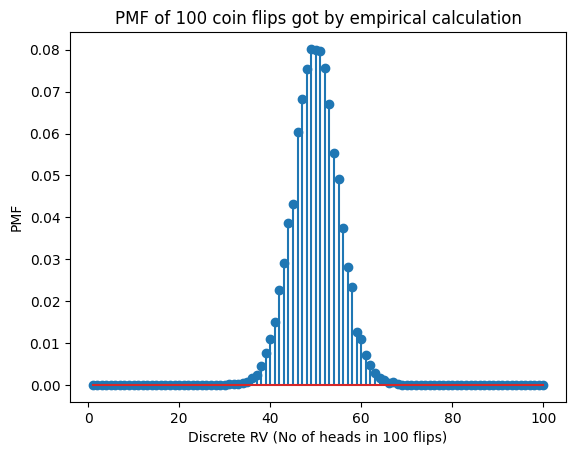

In [99]:
def simulate_coin_flips(n,p):
    N = 10000
    dist = torch.distributions.Bernoulli(p)
    # Generating N rows and n columns (Each row represents a single trial)
    samples = dist.sample((N,n)).numpy() 
    # Taking sum along the rows to get no of heads
    no_of_heads = np.sum(samples,axis=1)
    # The sample won't have extreme values For eg., 0,10,21,99,91,etc. because their probs are very less. As they are not 
    # in sample their frequency should be updated to 0. Below code identifies those outcomes which are missing from sample
    # and sets their frequency = 0.
    #Making a df of outcomes present in samples and their frequencies
    df = pd.DataFrame(no_of_heads,columns=["Heads"]).value_counts().sort_index().to_frame()
    df.index = df.index.map(lambda x:x[0])
    missing_vals = [i for i in range(1,n+1) if i not in df.index]
    # Making another df of missing values with 0 frequqncies
    df2 = pd.DataFrame([0]*len(missing_vals),index=missing_vals,columns=["count"])
    #Stacking both of them vertically
    Final_freq = pd.concat([df,df2],axis=0).sort_index()
    plt.stem(Final_freq.index,Final_freq['count']/N)
    plt.title('PMF of 100 coin flips got by empirical calculation')
    plt.xlabel("Discrete RV (No of heads in 100 flips)")
    plt.ylabel("PMF")
    

simulate_coin_flips(100,0.5)

#### Q3. (Optional)

A small café records the number of customers visiting per day for a month (30 days). The recorded data is as follows:

    customer_counts = [12, 15, 14, 10, 18, 16, 14, 12, 15, 11, 17, 14, 13, 19, 12, 18, 14, 10, 16, 15, 14, 13, 17, 12, 18, 16, 14, 11, 19, 13]
Compute the PMF for the given data and plot it using Matplotlib. Identify the most common number of daily customers and compare the distribution.

Text(0.5, 1.0, 'PMF Plot of Given list')

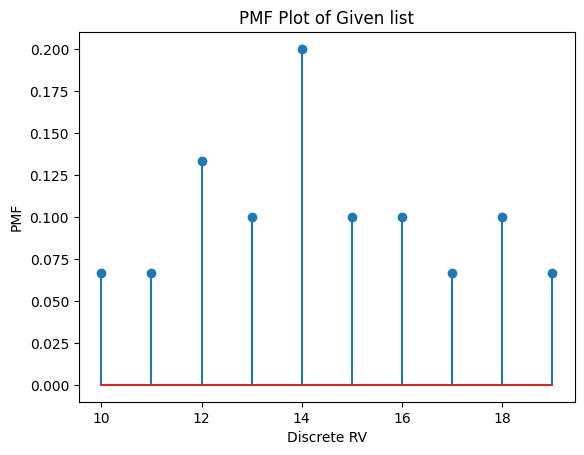

In [100]:
customer_counts = [12, 15, 14, 10, 18, 16, 14, 12, 15, 11, 17, 14, 13, 19, 12, 18, 14, 10, 16, 15, 14, 13, 17, 12, 18, 16, 14, 11, 19, 13]
#Noting the frequencies of unique values
cc = pd.DataFrame(customer_counts,columns=["Vals"]).value_counts().sort_index().to_frame()
#Finding their PMF
cc['pmf'] = cc['count']/len(customer_counts)
#Indexes are in (I1,) format (MultiIndex), so I converted them to I1 format 
cc.index = cc.index.map(lambda x:x[0])
plt.stem(cc.index,cc['pmf'])
plt.xlabel("Discrete RV")
plt.ylabel("PMF")
plt.title("PMF Plot of Given list")

# 3. **Cumulative Distribution Function**

#### Q1. (**Mandatory**)

Consider a discrete random variable 𝑋 with possible values 𝑥={1,2,3,4,5} and corresponding probability mass function (PMF):
$$ P(X=x)= \frac{x}{15} ,x∈{1,2,3,4,5}$$

where
𝑃(𝑋=𝑥) represents the PMF of 𝑋.

The Cumulative Distribution Function (CDF) is defined as:
 $$F_X(x) = P(X≤x)=\sum_{k≤x}
 P(X=k)$$


Your Task:
1. Compute the PMF values for each 𝑥∈{1,2,3,4,5}.
2. Compute the CDF $𝐹_X(𝑥)$ for each 𝑥.
3. Verify the relationship between PMF and CDF:
- $ P(X=x)=F_X(x)−F_X(x−1) $ for all 𝑥≥2.
- For 𝑥=1, $𝑃(𝑋=1)=𝐹_𝑋(1)$.
4. Print and compare the computed PMF values with the differences in CDF values to confirm the relationship.

In [101]:
#1.
def pmf1(x1): return x1/15 if x1 in range(1,6) else 0
for x1 in range(1,6):
    print(f"P(X={x1})={round(pmf1(x1),3)}")

P(X=1)=0.067
P(X=2)=0.133
P(X=3)=0.2
P(X=4)=0.267
P(X=5)=0.333


In [102]:
#2.
def cdf1(x2):
    cdf_val = 0
    for i in range(1,x2+1):
        cdf_val += pmf1(i)
    return cdf_val
for x2 in range(1,6):
    print(f"P(X<={x2})=",round(cdf1(x2),3))

P(X<=1)= 0.067
P(X<=2)= 0.2
P(X<=3)= 0.4
P(X<=4)= 0.667
P(X<=5)= 1.0


In [103]:
#3
for xi in range(2,6):
    print(f"CDF({xi}) - CDF({xi-1}) = {round(cdf1(xi)-cdf1(xi-1),3)} PMF = {round(pmf1(xi),3)}")

CDF(2) - CDF(1) = 0.133 PMF = 0.133
CDF(3) - CDF(2) = 0.2 PMF = 0.2
CDF(4) - CDF(3) = 0.267 PMF = 0.267
CDF(5) - CDF(4) = 0.333 PMF = 0.333


In [104]:
#4
dt = pd.DataFrame(data={
    "PMF": [round(pmf1(x),3) for x in range(2,6)],
    "CDF Difference": [round(cdf1(x)-cdf1(x-1),3) for x in range(2,6)]
})
dt['Equals'] = (dt['PMF'] == dt['CDF Difference'])
dt['deviation'] = round(dt['PMF'] - dt['CDF Difference'],3)
dt

,PMF,CDF Difference,Equals,deviation
0,0.133,0.133,True,0.0
1,0.200,0.200,True,0.0
2,0.267,0.267,True,0.0
3,0.333,0.333,True,0.0


#### Q2. (Optional)

  Write a Python function to compute the **CDF** for a given **discrete probability distribution**. Your function should:  

1. Take as input:  
   - A **list or NumPy array** of possible values of a discrete random variable.  
   - A corresponding **list or NumPy array** of probability mass function (PMF) values.  

2. Return:  
   - A list of CDF values corresponding to the input values.  

Additionally, perform the following:  

- Compute and plot the **CDF** for a **biased 6-sided die**, where the probability distribution is:  

| X   | 3   | 1   | 6   | 2   | 5   | 4   |
|-----|-----|-----|-----|-----|-----|-----|
| P(X)| 0.15| 0.05| 0.25| 0.10| 0.25| 0.20|


- Plot the **CDF as a step function** using **Matplotlib**.  

Text(0, 0.5, 'PMF')

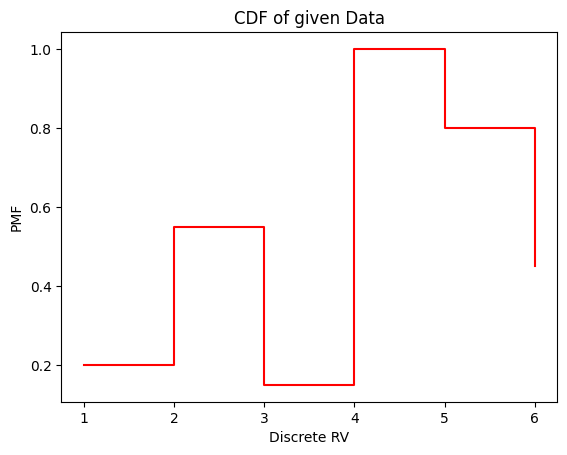

In [105]:
def compute_cdf(support,pmf):
    density = 0
    cdf = []
    for p in pmf:
        density+=p
        cdf.append(density)
    return np.array(cdf)
support = np.array([3,1,6,2,5,4])
pmfs = np.array([0.15,0.05,0.25,0.10,0.25,0.20])
cdf = compute_cdf(support,pmfs)
#Sorting the support and cdf for plotting
sorted_idxes = np.argsort(support)
cdf = cdf[sorted_idxes]
support = np.sort(support)
#Plotting the support
plt.step(support,cdf,where="post",color="red")
plt.title("CDF of given Data")
plt.xlabel("Discrete RV")
plt.ylabel("PMF")

#### Q3. (Optional)

Define a function pdf(x) representing a normal distribution.

$$
f(x) = \frac{1}{2\pi\sigma^2} e^{-\frac{(x-\mu)^2}{2\sigma ^2}}
$$

Now calcluate the CDF of this function and plot it along with the curve for the above normal distribution.

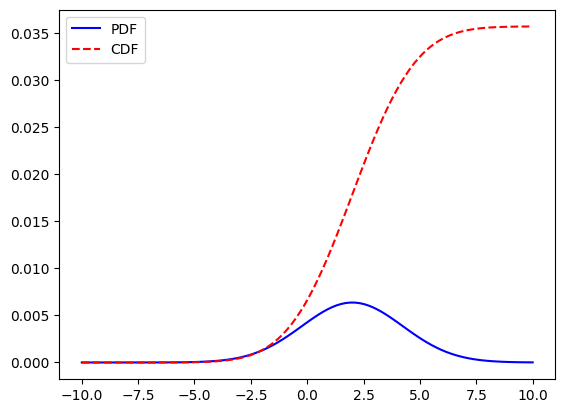

In [106]:
def normal(x,mu,sigma): return np.exp((-(x-mu)**2)/(2*sigma))/(2*np.pi*sigma**2)
x = np.linspace(-10,10,100)
n = normal(x,2,5)
import scipy.integrate as integrate
#Getting the cdf values corresponding to every x value in x array
cdf_values = [integrate.quad(normal, -10, ele, args=(2, 5))[0] for ele in x]
plt.plot(x, n, label="PDF", color="blue")
plt.plot(x, cdf_values, label="CDF", linestyle="dashed", color="red")
plt.legend()

# 4. **Expectation**

#### Q1. (**Mandatory**)
Simulate a game where you flip a coin three times. The reward system is as follows:


*   $8 for exactly 3 heads

*   $1 for exactly 2 heads,

*   $0 otherwise.

The cost to play the game is $1.5. Run the simulation for 10,000 trials and compute the average net gain, compare with theoretical expected net gain?


Answer: 
Theoretical Calculations
PMF is:
$$
F[X] = 
\begin{cases}
p, & \text{if }  x = 0 \\
1-p, & \text{if } x = 1
\end{cases}
$$
Let the reward function be g(x). g(x) is given as:
$$
g[X] = 
\begin{cases}
8, & \text{if }  x=3 \\
1, & \text{if }  x=2 \\
0, & \text{otherwise} 
\end{cases}
$$
Let us now calculate the theoretical Expected value of the new Random Variable g(X)
$$
\begin{align}
E[g(X)]
&=\sum_{x\in X} g(x)F(x) \\
&=\sum_{x=0}^{3} g(x)\binom{3}{x}p^x(1-p)^{3-x} \\
&= 1\binom{3}{2} (0.5)^2 (0.5)^(1) + 8\binom{3}{3} (0.5)^3 (0.5)^{0} \\
&= 1.375 \\
Net\_gain
&= 1.375 - 1.5 \\
&= -0.125    
\end{align}
$$
Thus, theoretically there will be am expected loss of -0.125 dollars. 


In [107]:
no_of_trials = 10000
#Consider head as success and we will make a random variable X distributed as Binomial(n,p) 
n1,p1 = 3,0.5
bd = torch.distributions.Binomial(n1,p1)
trials = bd.sample((no_of_trials,))
cost_to_play = 1.5 # In dollars

#Make a reward function which returns reward as per random variable x
def reward(xval1): return 8 if xval1==3 else 1 if xval1==2 else 0
theoretical_gain = -0.125 # Dollars
print("Theoretical gain is:",theoretical_gain,"dollars")
#Calculating the sample_gain
df2 = pd.DataFrame(trials,columns=["Samples"])
#Getting the rewards for every game out of the 10,000 games played
rewards = df2['Samples'].apply(lambda x:reward(x))
avg_gain = rewards.mean()
net_gain = avg_gain - cost_to_play
print("Net gain is:",round(net_gain,3),"dollars")

Theoretical gain is: -0.125 dollars
Net gain is: -0.195 dollars


#### Q2. (Optional)
Write a Python function that computes the expected value of a discrete random variable given its probability mass function (PMF). The function should take a dictionary where keys represent outcomes and values represent their corresponding probabilities.

Example:
```python
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
expected_value = compute_expected_value(pmf)
print(expected_value)  # Expected Output: 2.3

```




In [108]:
def compute_expected_value(pmf): 
    df = pd.DataFrame(data={
        "Outcome": pmf.keys(), 
        "Probs": pmf.values(), 
    })
    c = df.columns
    Ex = (df[c[0]]*df[c[1]]).sum()
    return Ex
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
expected_value = compute_expected_value(pmf)
print(expected_value) 


2.3


#### Q3. (Optional)

Given a discrete random variable with its probability mass function (PMF), compute the expected value of a function \(g(x)\). The function \(g(x)\) should be provided as input.

Example:
```python
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
g = lambda x: x**2
expected_value = compute_expected_value_of_function(pmf, g)
print(expected_value)


In [109]:
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
g = lambda x: x**2
def compute_expected_value_of_function(pmf,g):
    df = pd.DataFrame(data={
        "Outcome": pmf.keys(),
        "Probs": pmf.values()
    })
    Ex = (df['Probs']*(df['Outcome'].apply(g))).sum()
    return Ex
    
expected_value = compute_expected_value_of_function(pmf, g)
print(expected_value)

5.9


# 5. **Moments and Variance**

#### Q1. (**Mandatory**)
Write a function to compute the variance of a discrete random variable given its probability mass function.

Example:
```python
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
variance = compute_variance(pmf)
print(variance)


In [110]:
def compute_variance(pmf):
    df = pd.DataFrame(pmf.values(),index=pmf.keys(),columns=["PMF"])
    df['X'] = pd.Series([x for x in range(1,4)],index=[1,2,3])
    df['X^2'] = df['X']**2
    Ex = (df['X']*df['PMF']).sum()
    Ex2 = (df['X^2']*df['PMF']).sum()
    variance = Ex2 - Ex**2
    return variance
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
variance = compute_variance(pmf)
print(variance)

0.6100000000000012


#### Q2. (Optional)
Write a function to compute the k-th moment of a discrete random variable given its probability mass function.

Example:
```python
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
k = 3
moment = compute_moment(pmf, k)
print(moment)


In [111]:
pmf = {1: 0.2, 2: 0.3, 3: 0.5}
k = 3
def compute_moment(pmf,k):
    df = pd.DataFrame(data={
        "Outcome": pmf.keys(),
        "Probs": pmf.values()
    })
    Moment = (df['Probs']*(df['Outcome'].apply(lambda x: x**k))).sum()
    return Moment
    
moment = compute_moment(pmf, k)
print(moment)

16.1


#### Q3. (Optional)
Simulate and Estimate the variance of a given function \( f(x) \) when \( X \) is uniformly distributed over [a, b].

Example:
```python
import numpy as np
f = lambda x: x**2
a, b, N = 0, 1, 10000
variance = estimate_variance(f, a, b, N)
print(variance)


In [112]:
import numpy as np
f = lambda x: x**2
a, b, N = 0, 1, 10000
def estimate_variance(f, a, b, N):
    import scipy.integrate as integrate
    Ex = integrate.quad(lambda x: f(x)/(b-a),a,b)[0]
    Ex2 = integrate.quad(lambda x: (f(x)**2)/(b-a),a,b)[0]
    var = Ex2 - Ex**2
    return var
variance = estimate_variance(f, a, b, N)
print(variance)

0.0888888888888889


#### Q1. (**Mandatory**)
Write a function that simulates a Bernoulli-distributed random variable with a given probability \( p \).

Example:
```python
p = 0.7
outcome = bernoulli_trial(p)
print(outcome)  # Expected Output: 0 or 1


# 6. **Bernoulli Random Variables**

In [113]:
def bernoulli_trial(p):
    dist = torch.distributions.Bernoulli(p)
    return dist.sample()
p = 0.7
outcome = bernoulli_trial(p)
print(outcome.item())

1.0


#### Q2. (Optional)
Given \( p \), the probability of success in a Bernoulli distribution, compute its expectation and variance.

Example:
```python
p = 0.5
expectation, variance = bernoulli_stats(p)
print(expectation, variance)


In [114]:
p = 0.5
def bernoulli_stats(p):
    return p,p*(1-p)
expectation, variance = bernoulli_stats(p)
print(expectation, variance)

0.5 0.25


#### Q3. (Optional)
Write a function that simulates `N` Bernoulli trials and computes the proportion of successes.

Example:
```python
p = 0.3
N = 1000
proportion = simulate_bernoulli(p, N)
print(proportion)


In [115]:
p = 0.3
N = 1000
def simulate_bernoulli(p,N):
    dist = torch.distributions.Bernoulli(p)
    sample = dist.sample((N,)).numpy()
    sp = sample.sum()/N
    return sp
    
proportion = simulate_bernoulli(p, N)
print(proportion)

0.296


In [116]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import math
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# 7. **Binomial Distribution**

#### Q1. (**Mandatory**)
Write a Python function that simulates a Binomial random variable. The function should take three inputs:
- `n` (number of trials)
- `p` (probability of success)
- `size` (number of random values to generate)

Plot a histogram of the generated values for `n=10`, `p=0.5`, and `size=1000`.


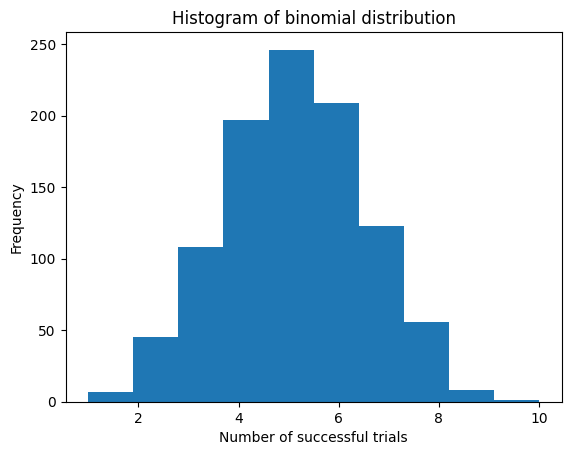

In [117]:
def binomial_plot(n,p,size):
  bino_dist=dist.Binomial(n,p)  #this will return a tensor vector of length n, containing the number of successful outputs for the n times
  samples=bino_dist.sample((size,))
  plt.hist(samples)
  plt.plot()
  plt.xlabel("Number of successful trials")
  plt.ylabel("Frequency")
  plt.title("Histogram of binomial distribution")
  plt.show()

binomial_plot(10,0.5,1000)


#### Q2. (Optional)
Write a Python program that:
1. Computes the probability mass function (PMF) of a Binomial distribution.
2. Plots the PMF for `n=20` and `p=0.3`.


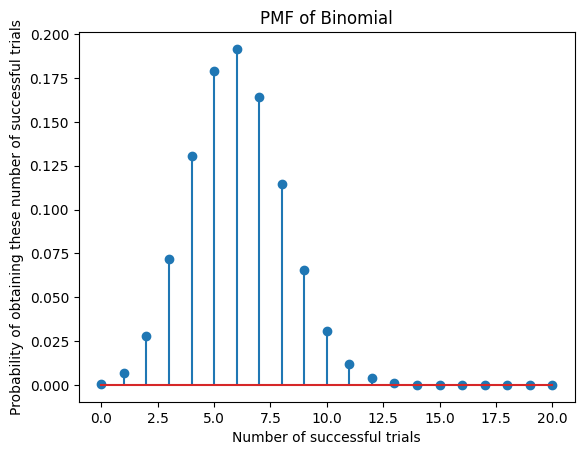

In [118]:
def pmf_calculator(n,p,k): #k is the number of success
    comb=math.comb(n,k)
    pmf=comb*((1-p)**(n-k))*(p**k)
    return pmf
def pmf_plot(n,p):
    k=np.arange(n+1)
    pmf_lis=[pmf_calculator(n,p,i) for i in range(0,n+1)]
    plt.stem(k,pmf_lis)
    plt.xlabel("Number of successful trials")
    plt.ylabel("Probability of obtaining these number of successful trials")
    plt.title("PMF of Binomial")  
    plt.plot()
    plt.show()
pmf_plot(20,0.3)


#### Q3. (Optional)
Simulate a fair coin being flipped 100 times and count the number of heads. Repeat this experiment 1000 times and visualize the distribution using a histogram. Explain how this relates to the Binomial distribution.

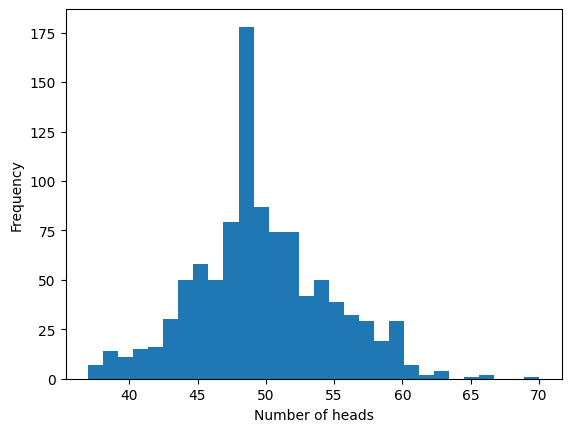

In [119]:
def binomial_plot(n,p,size):
  bino_dist=dist.Binomial(n,p)
  samples=bino_dist.sample((size,))  #samples counts the number of successful trials that is the number of heads
  plt.hist(samples,bins=30)
  plt.plot()
  plt.xlabel("Number of heads")
  plt.ylabel("Frequency")
  plt.show()
#each flipping of coin is a benoulli distribution, since it is repeated multiple times therefore this is a binomial distribution
binomial_plot(100,0.5,1000)

Relating binomial and bernoulli <br>
#each flipping of coin is a benoulli distribution, since it is repeated multiple times therefore this is a binomial distribution


# 8. **Geometric Distribution**

#### Q1. (**Mandatory**)
#### Simulating Geometric Distribution
Write a Python function that generates random numbers from a Geometric distribution. The function should take:
- `p` (probability of success)
- `size` (number of values to generate)

Plot a histogram for `p=0.3` and `size=1000`.

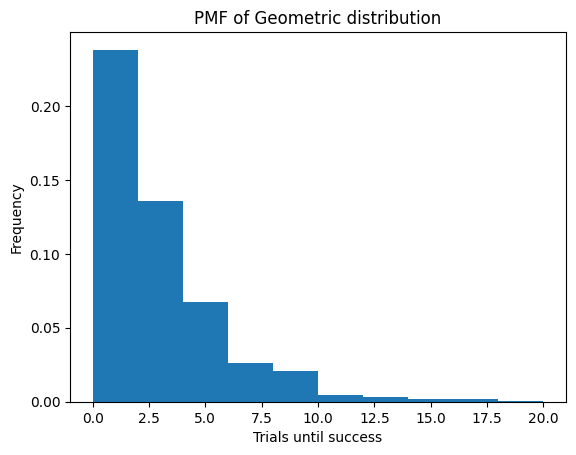

In [120]:
def geometric(p,size):
  geo_dist=dist.Geometric(p)
  samples=geo_dist.sample((size,))
  return samples
plt.hist(geometric(0.3,1000),bins=10,density=True)
plt.plot()
plt.title("PMF of Geometric distribution")
plt.xlabel("Trials until success")
plt.ylabel("Frequency")
plt.show()


#### Q2. (Optional)
#### Expected Number of Trials
Create an interactive Python program that uses `ipywidgets` and `matplotlib` to visualize the probability mass function (PMF) of the Geometric distribution. Users can adjust the probability of success \( p \) and the maximum number of trials \( k \) to display.

Answer:
Geometric Distribution is:
$$
P(X=k)=(1−p)^{k−1}p  

$$
where k = {1,2,3,4,...}



In [121]:
import ipywidgets as widgets
from ipywidgets import interact
kSlider = widgets.IntSlider(min=2,max=100,value=10,step=1,description="k")
pSlider = widgets.FloatSlider(min=0,max=1,step=0.05,value=0.3,description="p")
def plot_geometric_dist(k,p):
    def f(p,x): return p*((1-p)**(x-1))
    x = np.arange(1,k+1,1)
    plt.stem(x,f(p,x))
    plt.xlabel("Continuous RV")
    plt.ylabel("Density")
    plt.title("PMF of Geometric distribution")
interact(plot_geometric_dist,k=kSlider,p=pSlider)

interactive(children=(IntSlider(value=10, description='k', min=2), FloatSlider(value=0.3, description='p', max…

<function __main__.plot_geometric_dist(k, p)>

#### Q3. (Optional)
#### Estimating `p` from Sample Data
Generate a dataset of 500 Geometric random variables with `p=0.4`. Then, estimate `p` from the data using the formula:

$$\hat{p} = \frac{1}{\text{sample mean}}$$

Compare the estimated value with the true `p=0.4` and compute the percentage error.

In [122]:
def geometric(p,size):
  geo_dist=dist.Geometric(p)
  samples=geo_dist.sample((size,)) + 1
  return samples
samples=geometric(0.4,500)
mean_of_sample=torch.mean(samples)
P=1/mean_of_sample
print("estimated value of p:",P.item())

print("Percentage error in p=",(abs(P-0.4)*250).item(),"%")

estimated value of p: 0.39308178424835205
Percentage error in p= 1.729555368423462 %


### Why did I add 1 to the samples?
Traditonally geometric distribution is $$P(X) = (1-p)^{k-1} p $$ <br>
PyTorch writes geometric distribution slightly differently. It considers k failures before first success <br>
For PyTorch, $$P(Y) = (1-p)^{k} p$$
Thus, we add 1 to make the samples as per traditional formula

# 9. **Poisson Distribution**

#### Q1. (**Mandatory**)
Write a Python function that generates Poisson random variables. The function should take:
- `λ` (expected number of events per interval)
- `size` (number of values to generate)

Plot a histogram for `λ=5` and `size=1000`.

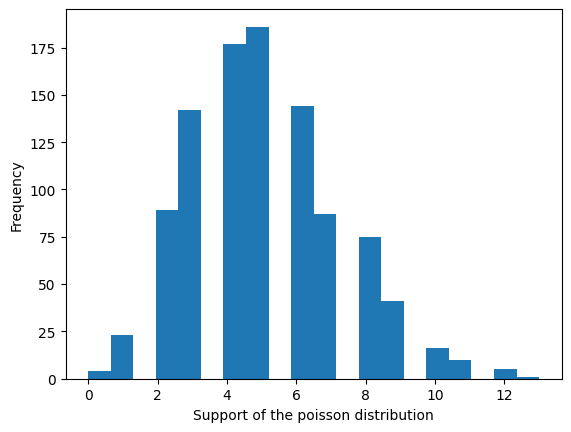

In [123]:
def poisson_dist(lambdaa,size):
  x=size
  pois_dist=dist.Poisson(lambdaa)
  samples=pois_dist.sample((size,))
  return samples
# print(poisson_dist(5,1000))
plt.hist(poisson_dist(5,1000),bins=20)
plt.plot()
plt.xlabel("Support of the poisson distribution")
plt.ylabel("Frequency")
plt.show()


#### Q2. (Optional)
Generate 1000 samples from a Binomial distribution with `n=100` and `p=0.05`. Then, generate 1000 samples from a Poisson distribution with `λ=n*p=5`. Compare their histograms and explain why the Poisson distribution approximates the Binomial distribution for large `n` and small `p`.

tensor([ 8.,  3.,  4.,  5.,  6.,  4.,  9.,  7.,  4.,  5.,  5.,  4.,  6.,  6.,
         3.,  5.,  6.,  6.,  4.,  7.,  4.,  5.,  9.,  3.,  5.,  9.,  7., 12.,
        10.,  6.,  4.,  5.,  3.,  5.,  5.,  3.,  6.,  5.,  3.,  5.,  4.,  3.,
         3.,  4.,  6.,  1.,  2.,  4.,  3.,  4.,  4.,  0.,  3.,  6.,  4.,  1.,
         8.,  5., 10.,  7.,  5.,  4.,  9.,  4.,  6.,  2.,  5.,  6.,  4.,  5.,
         7.,  3.,  2.,  4.,  4.,  9.,  3.,  5.,  4.,  6.,  2.,  6.,  4.,  3.,
         3.,  3.,  7.,  6.,  7.,  2., 11.,  5.,  5.,  7.,  7.,  8.,  5.,  6.,
         4.,  7., 11.,  7.,  5., 12.,  4.,  4.,  6.,  3.,  2.,  8.,  3.,  6.,
         3.,  4.,  2.,  4.,  4.,  6.,  3.,  5.,  8.,  6.,  4.,  5.,  5.,  5.,
         4.,  3., 10.,  2.,  7.,  7.,  2.,  6.,  8.,  5.,  3.,  4.,  4.,  5.,
         3.,  4.,  5.,  8.,  5.,  6.,  3.,  4.,  4.,  3.,  6.,  7.,  7.,  6.,
         5.,  4.,  7.,  1.,  4.,  2.,  3.,  6.,  4.,  1.,  3.,  8.,  7., 10.,
         3.,  3., 10.,  6.,  4.,  5.,  8.,  4., 10.,  7.,  5.,  

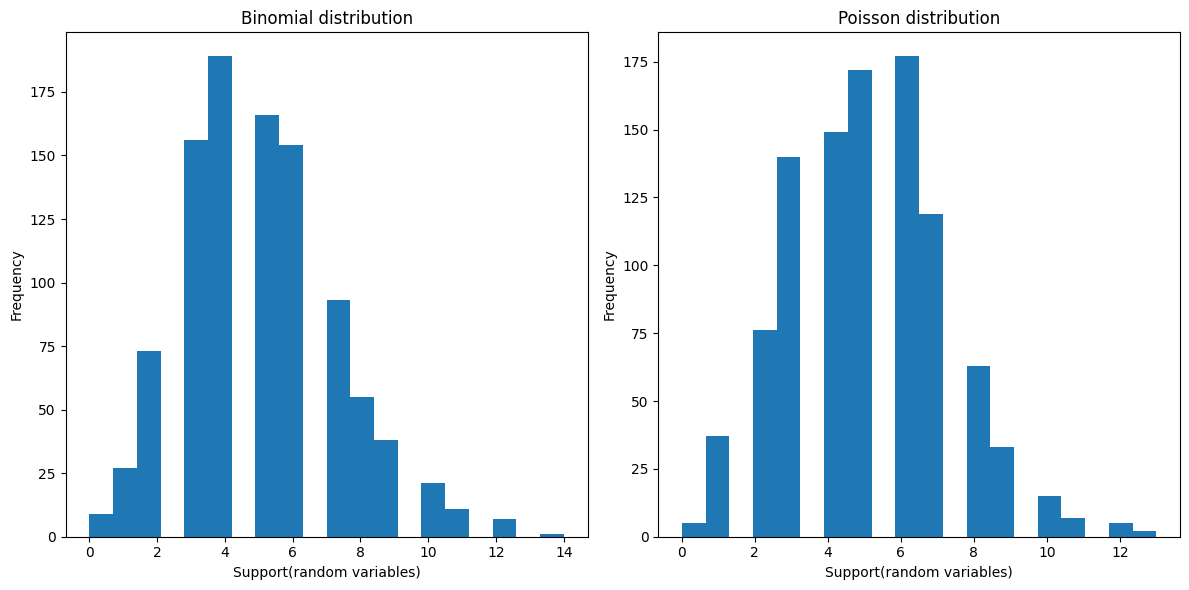

In [124]:
def binomial_plot(n,p,size):
  bino_dist=dist.Binomial(n,p)
  samples=bino_dist.sample((size,))
  return samples
bino=binomial_plot(100,0.05,1000)
print(bino)
poiso=poisson_dist(5,1000)
print(poiso)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.hist(bino,bins=20)
ax1.plot()
ax1.set_xlabel("Support(random variables)")
ax1.set_ylabel("Frequency")
ax1.set_title("Binomial distribution")
ax2.hist(poiso,bins=20)
ax2.set_xlabel("Support(random variables)")
ax2.set_ylabel("Frequency")
ax2.set_title("Poisson distribution")
ax2.plot()
fig.tight_layout()

#For large value of n and small value of p, the probability of a particular random variable becomes very small, indicating that the chance of occuring of that value of n is small
#(almost zero) as if it was a just a point in range of continous random varialbe, for which the probability is zero for a particular point

#### Q3. (Optional)
A call center receives calls at an average rate of 3 calls per minute. Assume the number of calls follows a Poisson distribution.
1. Compute the probability of receiving exactly 5 calls in a minute.
2. Compute the probability of receiving at most 5 calls.

In [125]:
#1.
pois_dist=dist.Poisson(3)
print(pois_dist.log_prob(torch.tensor(5)).exp())

tensor(0.1008)


In [126]:
#2.
prob=sum([pois_dist.log_prob(torch.tensor(i)).exp() for i in range(0,6)])
print(prob)

tensor(0.9161)


# 10. **Probability Density function**

#### Q1. (**Mandatory**)
Implement a piecewise PDF defined as:

$$
f(x) =
\begin{cases}
0.5x & \text{if } 0 \leq x \leq 1 \\
2 - x & \text{if } 1 < x \leq 2 \\
0 & \text{otherwise}
\end{cases}
$$

Compute P(0.5≤X≤1.5) analytically and verify using numerical integration.

Plot the PDF and highlight the area under the curve for the computed probability.

## Note: As per the below calculation, we figured out that above pdf is not a valid pdf as the integral over $-\infty$ to $\infty$ is not 1 but 0.75

#### Answer
Let us first normalise the PDF. Assume the area under the curve of CDF to be c. 
$$
\begin{align}
c &= \int_{-\infty}^{\infty} f(x) \, dx  \\
&= \int_{0}^{1}0.5x\,dx + \int_{1}^{2}(2-x)\,dx \\
&=0.75
\end{align}
$$

Thus, our normalised PDF will be
$$
\begin{align}
f_{N}(x) &= \frac{f(x)}{0.75}  \\
\end{align}
$$
$$
f_{N}(x) = 
\begin{cases}
\frac{2}{3}x, \text{ if} & 0 \leq x \leq 1\\
\frac{4}{3}(2-x), \text{ if} & 1 \leq x \leq 2\\
0 & otherwise
\end{cases}
$$

Let us first calculate the CDF of f(x)

1. For $ x \in [0,1] $ :
$$ F_N[X>x] = \int_{0}^{x}\frac{2}{3}x\,dx = \frac{2}{3}\frac{[x^2]_{0}^{x}}{2} = \frac{1}{3}x^2 $$

2. For $ x \in [1,2] $ :
$$ 
\begin{align}
F_N[X > x] &= \int_{0}^{1} \frac{2}{3}x \,dx + \int_{1}^{x} \frac{4}{3} (2-x) \,dx  \\
&= \frac{1}{3} - \frac{4}{3} \frac{[(2-x)^2]_1^x}{2}  \\
&= \frac{1}{3} - \frac{2}{3} (2-x)^2 + \frac{2}{3} \\
&= 1 - \frac{2}{3} (2-x)^2
\end{align}
$$

3. For $ x \in [2,\infty] $ :
$$ 
\begin{align}
F_N[X > x] &= \int_{0}^{1} \frac{2}{3}x \,dx + \int_{1}^{2} \frac{4}{3} (2-x) \,dx  \\
&= \frac{1}{3} - \frac{4}{3} \frac{[(2-x)^2]_1^2}{2}  \\
&= \frac{1}{3} - \frac{2}{3} (2-2)^2 + \frac{2}{3} \\
&= 1
\end{align}
$$

So the cdf will be : 
$$
F_N[X \leq x] = 
\begin{cases}
\frac{x^2}{3}  & \text{if } & 0 \leq x \leq 1 \\
1 - \frac{2}{3} (2-x)^2 & \text{if } & 1 < x \leq 2 \\
1 & \text{if } & x > 2 
\end{cases}
$$

In [127]:
def pdf(x):return 0.5*x if 0<=x<=1 else 2-x if 1<x<=2 else 0

def npdf(x):return 2*x/3 if 0<=x<=1 else (2-x)*(4/3) if 1<x<=2 else 0
#Computing P(0.5<=X<=1.5 analytically)
def cdf(x):return (x**2)/3 if 0<=x<=1 else 1-(2*(2-x)**2)/3 if 1<x<=2 else 1
print("Analytical Approach: P[0.5<=X<=1.5] = ",cdf(1.5)-cdf(0.5))

#Computing P(0.5<=X<=1.5 by numerical integration)
from scipy.integrate import quad
def f1(x): return 2*x/3
def f2(x): return 4*(2-x)/3
ans1,e1=quad(f1,0.5,1)
ans2,e2=quad(f2,1,1.5)
print("So, the value of numerical integration will be:",ans1+ans2)

Analytical Approach: P[0.5<=X<=1.5] =  0.75
So, the value of numerical integration will be: 0.75


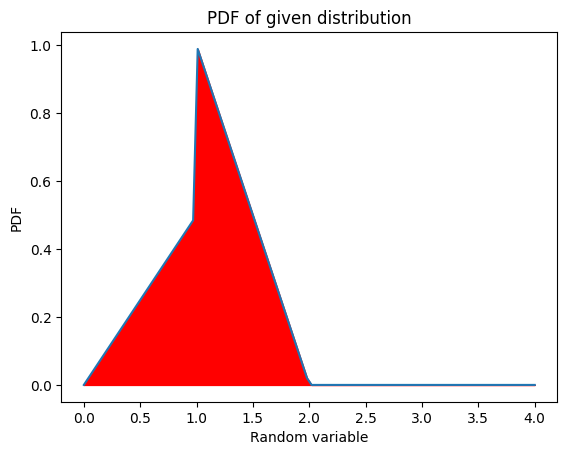

In [128]:
#Plotting the pdf
def pdf(x):
  if (x>=0) and (x<=1):
    return 0.5*x
  elif (x>1) and (x<=2):
    return 2-x
  return 0
x=np.linspace(0,4,100)
y=np.array([pdf(i) for i in x])
plt.plot(x,y)
plt.fill_between(x,y,color="red")
plt.title("PDF of given distribution")
plt.xlabel("Random variable")
plt.ylabel("PDF")
plt.show()

#### Q2. (Optional)
Write a Python program to estimate the probability density function of a given dataset using a histogram.

* Generate or load a dataset (e.g., from a normal distribution with mean = 0 and standard deviation = 1, sample size = 1000).
* Compute the histogram with an appropriate number of bins.
* Normalize the histogram so that it represents a probability density function and plot the estimated PDF.

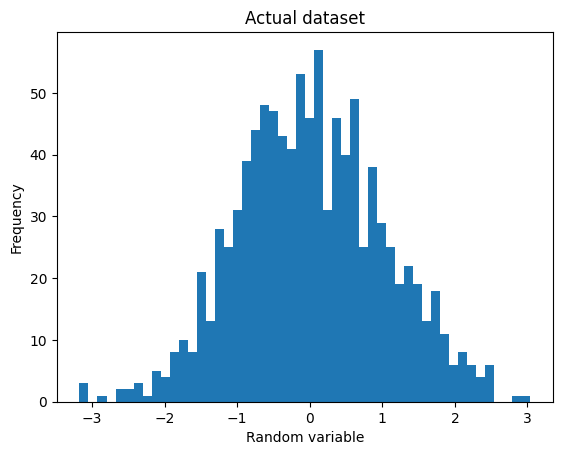

In [129]:
def normal_dis(mean,std,size):
  nor_dist=dist.Normal(mean,std)
  samples=nor_dist.sample((size,))
  return samples
dataset=normal_dis(0,1,1000)
# plt.hist(dataset,bins=50)
counts, bin_edges, bars = plt.hist(dataset, bins=50)
plt.plot()
plt.title("Actual dataset")
plt.xlabel("Random variable")
plt.ylabel("Frequency")
plt.show()

Now we need to normalize the histogram plot so that area under the curve is 1. We can do this by dividing each of the bins by the: <br>
Total area of the histogram plot=(Number of samples) * (Width of each bin)

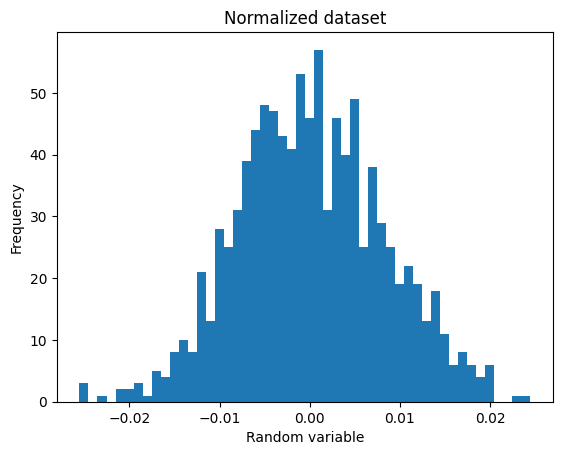

In [130]:
binwidth=bin_edges[1]-bin_edges[0]
Area=1000*(binwidth)
newdata=dataset/Area
plt.hist(newdata, bins=50)
plt.plot()
plt.title("Normalized dataset")
plt.xlabel("Random variable")
plt.ylabel("Frequency")
plt.show()

#### Q3. (Optional)
Random variable X defined as:

Discrete PMF: P(X=0)=0.2.

Continuous PDF: For 1≤x≤3, f(x)=0.4.

X is undefined outside {0}∪[1,3].

* a) Confirm the total probability is 1.
* b) Compute P(1.5≤X≤2.5).

In [131]:
def pmf(x):
  if x==0:
    return 0.2
  elif (x>=1)and(x<=3):
    return 0.4
  else: return 0
total_prob=0.2+quad(pmf,0,3)[0] #adding the probability of discrete pmf with continous pmf
print(total_prob)

1.0


In [132]:
#Let the given pmf P(1.5≤X≤2.5) be P
P=round(quad(pmf,1.5,2.5)[0],2)
print("P(1.5≤X≤2.5)=",P)

P(1.5≤X≤2.5)= 0.4


# 11. **Expectation(continuous)**

#### Q1. (**Mandatory**)
Implement a function to compute E[X] for a continuous random variable with a piecewise probability density function (PDF).

```python
def expectation_piecewise_pdf(intervals: list, funcs: list) -> float:
    """
    Compute E[X] for a piecewise PDF defined over intervals.
    
    Args:
        intervals: List of tuples defining intervals, e.g., [(0, 1), (1, 2)]
        funcs: List of functions corresponding to each interval's PDF
    """
    
    # Example:
    def f1(x): return x   # For 0 <= x <= 1
    def f2(x): return 2 - x  # For 1 < x <= 2
    expectation_piecewise_pdf([(0, 1), (1, 2)], [f1, f2]) ≈ 1.0



In [133]:
def expectation_piecewise_pdf(intervals: list, funcs: list) -> float:
  area=0
  for i in range(len(intervals)):
    area+=quad(funcs[i],intervals[i][0],intervals[i][1])[0]
  return print(area)
def f1(x): return x   # For 0 <= x <= 1
def f2(x): return 2 - x  # For 1 < x <= 2
expectation_piecewise_pdf([(0, 1), (1, 2)], [f1, f2])

1.0


#### Q2. (Optional)
Compute E[g(X)] for a continuous random variable X with PDF f(x) and transformation g, using numerical integration.
```python
def expectation_transform(g, pdf, lower: float, upper: float) -> float:
    """
    Compute E[g(X)] where X has the given PDF.
    
    Args:
        g: Function to transform X (e.g., lambda x: x**2)
        pdf: Probability density function of X
        lower: Lower bound of X's support
        upper: Upper bound of X's support
    """
    # Example:
    f = lambda x: 2*x  # PDF for X ~ Uniform(0,1) transformed by Y=2X
    expectation_transform(lambda x: x, f, 0, 1) ≈ 2/3
  


In [134]:
def expectation_transform(g, pdf, lower: float, upper: float) -> float:
  def F(x):
    return g(x)*pdf(x)
  print(quad(F,lower,upper)[0])
f = lambda x: 2*x
expectation_transform(lambda x: x, f, 0, 1)

0.6666666666666667


# **12. Cumulative distribution function for continuous random variables**

#### Q1. (**Mandatory**)
Write a function to compute and plot the Cumulative Distribution Function (CDF) for a Uniform continuous random variable
𝑋 ∼ 𝑈(𝑎,𝑏) given the probability density function (PDF):


$$ f_X(x)= \begin{cases}
\frac{1}{b−a} & ,\text a≤x≤b \\
0 & ,\text {otherwise}
\end {cases}
$$

Your function should:

1. Take a and b (where 𝑎 < 𝑏) as inputs.
2. Compute the CDF $𝐹_𝑋(𝑥)$
3. Generate an array of 𝑥-values and compute $ 𝐹_𝑋(𝑥) $.
4. Plot the CDF curve using Matplotlib.​















Answer <br>
CDF of random variable U ~ Uniform(a,b) is given by: <br>

$$
F_X[X] = 
\begin{cases}
0 & \text{if } & 0 \leq x \leq a \\
\frac{x-a}{b-a} & \text{if } & a \leq x \leq b \\
1 & \text{if } & x > b
\end{cases}
$$

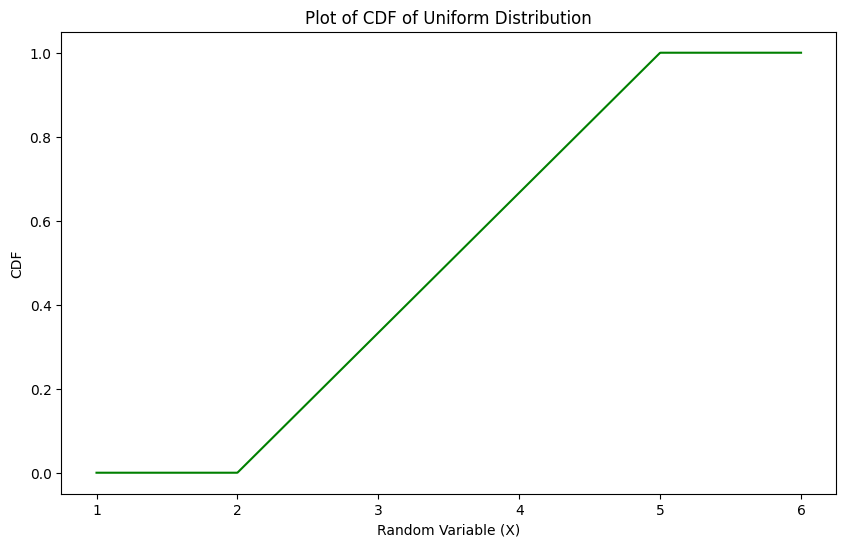

In [135]:
def f(a,b,N=10000):
    if(a>=b): return
    #Making the cdf function as per a and b
    def cdf(a,b,x):
        if(x<=a): return 0
        elif(a<x<b): return (x-a)/(b-a)
        else: return 1
    # Generating an array of x values
    xvals = np.linspace(a-1,b+1,1000)
    #Computing Fx[X]
    dist = pd.DataFrame(xvals,columns=["X"])
    dist['CDF'] = dist['X'].apply(lambda x: cdf(a,b,x))
    #Plotting the CDF using Matplotlib
    fig,axes = plt.subplots(figsize=(10,6))
    axes.plot(xvals,dist['CDF'],color="green")
    axes.set_xlabel("Random Variable (X)")
    axes.set_ylabel("CDF")
    axes.set_title("Plot of CDF of Uniform Distribution")
f(2,5)  


#### Q2. (Optional)
A continuous random variable 𝑋 follows an Exponential distribution with a given rate parameter 𝜆. The probability density function (PDF) of 𝑋 is:
    $$ f_X(x)=λe^{−λx} ,x≥0 $$

Your task is to derive and compute the CDF $𝐹_𝑋(𝑥)$ of the given exponential distribution for a given 𝜆.

Instructions:
1. Write a function that takes 𝑥 and 𝜆 as input and returns the cumulative distribution function (CDF) $ 𝐹_𝑋(𝑥)$.
2. Compute the CDF for different values of 𝑥 in the range [0, 5].
3. Plot the CDF curve for a given 𝜆.

In [136]:
#1.
def PDF_expo(lambdaa,t):
  return lambdaa*(np.e)**(-lambdaa*t)
def CDF(x,lambdaa):
  return quad(PDF_expo,0,x,args=(lambdaa,))[0]
# print(CDF(10,3))

In [137]:
#2.
A=np.linspace(0,5,10)
B=np.array([CDF(i,3) for i in A])
print(B)

[0.         0.05514797 0.09393474 0.10661915 0.11002702 0.11086184
 0.11105562 0.11109904 0.11110853 0.11111057]


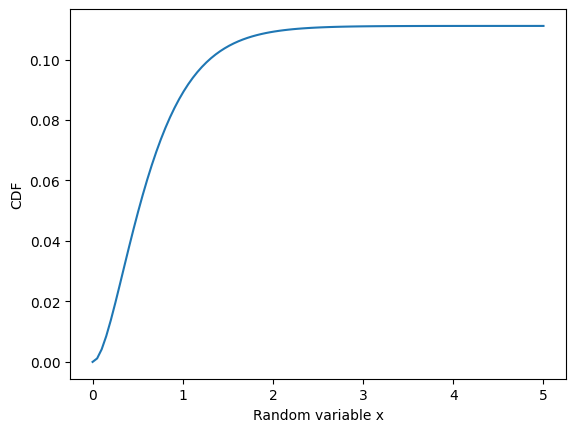

In [138]:
#3.
A=np.linspace(0,5,100)
plt.plot(A,np.array([CDF(i,3) for i in A]))
plt.xlabel("Random variable x")
plt.ylabel("CDF")
plt.show()

#### Q3. (Optional)
A continuous random variable 𝑋 follows an Exponential distribution with a rate parameter 𝜆. The PDF of 𝑋 is given as:
$$ 𝑓_𝑋(𝑥)=𝜆𝑒^{−𝜆𝑥},𝑥≥0 $$

Your task is to compute the probability 𝑃(1≤𝑋≤3) using two different approaches:

(a) PDF Approach:
Compute the probability using numerical integration of the PDF over the interval [1,3].

(b) CDF Approach:
Compute the probability using the CDF formula.


In [139]:
def PDF_expo(lambdaa,t):
  return lambdaa*(np.e)**(-lambdaa*t)
def CDF(x,lambdaa):
  return quad(PDF_expo,0,x,args=(lambdaa,))[0]
#a. let  𝑃(1≤𝑋≤3)=P, taking lambdaa=5
P=quad(PDF_expo,1,3,args=(5,))[0]
print(P)

0.0016169115022953912


In [140]:
#b. lambdaa=5
P=CDF(x=3,lambdaa=5)-CDF(x=1,lambdaa=5)
print(P)

0.0016169115022954053



# 13. **Mean, Mode, and Median**  
*(Refer to https://probability4datascience.com/slides/Slide_4_04.pdf)*



#### Q1. (Optional)
#### Compute Summary Statistics:
   Using a numerical dataset, write a Python snippet to compute the mean, median, and mode using built-in libraries.  



In [141]:
import ipywidgets as widgets
from ipywidgets import interact
def gen_data(N):
    data = pd.Series(torch.randint(1,100,(N,)).numpy())
    display(data.head(10))
    print("Mean: ",data.mean())
    print("Median: ",data.median())
    print("Mode: ",data.mode()[0])
n = widgets.IntSlider(min=100,max=1500,step=50,value=500,description="Size")
interact(gen_data,N=n)  

interactive(children=(IntSlider(value=500, description='Size', max=1500, min=100, step=50), Output()), _dom_cl…

<function __main__.gen_data(N)>

#### Q2. (**Mandatory**)
#### Visualize Distribution with Markers:  
   Generate a sample (e.g., from a normal distribution) and plot its histogram. Then mark the mean (red), median (green), and an approximate mode (blue, as the bin with maximum count) on the plot.  
   



Answer
## Probability Density Function of Normal Distribution

The probability density function (PDF) of a normal distribution is given by:

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

where:
-  $ \mu $  is the mean,
-  $ \sigma $ is the standard deviation.

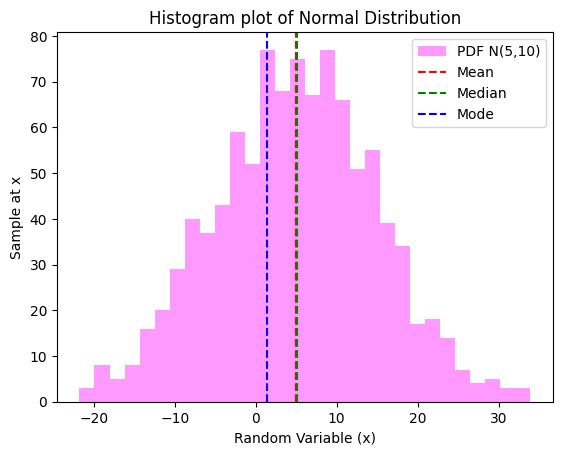

In [142]:
def plot_normal_hist(mu,sigma,N=1000,bins=30):
    dist = torch.distributions.Normal(mu,sigma)
    samples = dist.sample((N,)).numpy()
    plt.hist(samples,bins=bins,alpha=0.4,color="magenta",label=f"PDF N({mu},{sigma})")
    samples = pd.Series(samples)
    
    plt.axvline(samples.mean(),color="red",label="Mean",linestyle="dashed")
    plt.axvline(samples.median(),color="green",label="Median",linestyle="dashed")
    
    #Calculating the mode (Mid of bin with maximum freq) 
    hist, bin_edges = np.histogram(samples,bins)
    maxFreqBinIndex = np.argmax(hist)
    mode = (bin_edges[maxFreqBinIndex] + bin_edges[maxFreqBinIndex+1])/2 
    plt.axvline(mode,color="blue",label="Mode",linestyle="dashed")
    
    plt.xlabel("Random Variable (x)")
    plt.ylabel("Sample at x")
    plt.title("Histogram plot of Normal Distribution")
    plt.legend()
    plt.show()
plot_normal_hist(5,10)

### Q3. (Optional)
#### Sample vs. Theoretical Comparison:
   Generate 1000 samples from a known distribution (e.g., Uniform over [0, 10]) and compute the sample mean, median, and mode. Compare these with the theoretical values (mean = 5, median = 5).  



In [143]:
dist1 = torch.distributions.Uniform(0,10)
sample_size = 1000
samples = pd.Series(dist1.sample((sample_size,)))
data = pd.DataFrame(data={
        "Sample": [samples.mean(),samples.median()],
    "Theoretical": [dist1.mean.item(),((dist1.low + dist1.high)/2).item()]
}, index=["Mean","Median"])
data['Deviation(Theoretical - Sample)"'] = data["Theoretical"] - data["Sample"]
data

,Sample,Theoretical,"Deviation(Theoretical - Sample)"""
Mean,5.083077,5.0,-0.083077
Median,5.104854,5.0,-0.104854


# 14. **Uniform Random Variables**  
*(Refer to https://probability4datascience.com/slides/Slide_4_05.pdf)*


#### Q1. (**Mandatory**)
#### Simulate and Plot PDF & CDF:  
   Simulate a Uniform random variable over [2, 5] and plot its PDF and CDF using matplotlib, matching the formulas in the slide.  
  

# Probability Density Function of Uniform Distribution  

The probability density function (PDF) of a uniform distribution is given by:  

$$
f(x) =
\begin{cases} 
\frac{1}{b - a}, & a \leq x \leq b \\
0, & \text{otherwise}
\end{cases}
$$
where:  
- a is the lower bound,  
- b is the upper bound.  


In [144]:
#Making the Uniform distribution from scratch
a,b = 2,5
sample_size = 1000
dist2 = pd.DataFrame(data={
    "x":np.linspace(-a-10,b+10,sample_size),
}) 
y = 1/(b - a)
dist2['y'] = dist2['x'].apply(lambda x: y if(a<= x <= b) else 0)
dist2.head()

,x,y
0,-12.000000,0.0
1,-11.972973,0.0
2,-11.945946,0.0
3,-11.918919,0.0
4,-11.891892,0.0


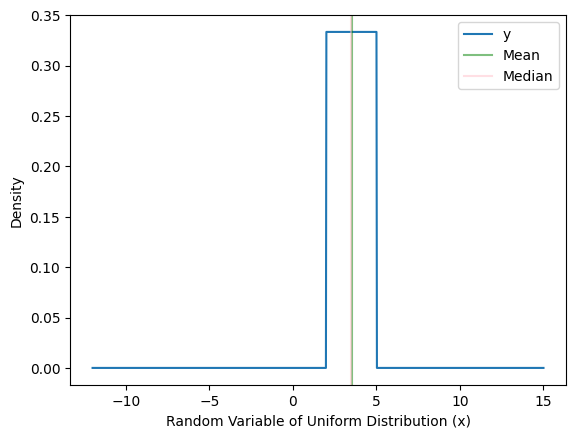

In [145]:
#plotting the PDF
dist2.plot(x='x',y='y',xlabel="Random Variable of Uniform Distribution (x)",
        ylabel = "Density")
dx = np.diff(dist2['x']).mean()
mean_data = (dist2['x']*dist2['y']).sum() * dx
median = (a+b)/2
plt.axvline(x=mean_data,color='green',label="Mean",alpha=0.5)
plt.axvline(x=median,color='pink',label="Median",alpha=0.5)
plt.legend()
plt.show()

<Axes: title={'center': 'CDF of Uniform Distribution'}, xlabel='Random Variable of Uniform Distribution', ylabel='Cummulative Sum'>

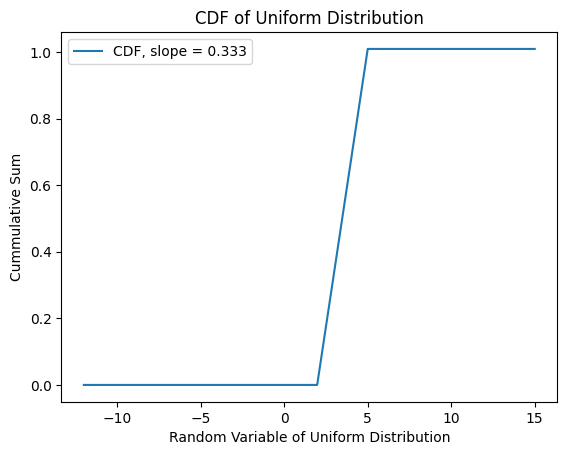

In [146]:
#Plotting the CDF
dist2['CDF'] = np.cumsum(dist2['y']*dx)
slope = round(1/(b-a),3)
dist2.plot(x='x',y='CDF',xlabel="Random Variable of Uniform Distribution",
        ylabel="Cummulative Sum",title="CDF of Uniform Distribution",label = f"CDF, slope = {slope}")   


#### Q2. (Optional)
#### Compute Theoretical Moments:
   Calculate the theoretical mean and variance for a Uniform(a, b) random variable with a = 2 and b = 5 using the formulas from the slide.  
  

In [147]:
k = 1
a,b = 2,5

## Theoretical mean of Uniform(a,b) is <br>
$$
\frac{a+b}{2}
$$
<br>

## Theoretical variance of Uniform(a,b) is <br>

$$
\frac{(b-a)^2}{12}
$$



In [148]:
print("Theoretical Mean of Uniform(a,b) = ",(a+b)/2)
print("Theoretical Variance of Uniform(a,b) = ",((b-a)**2)/12)

Theoretical Mean of Uniform(a,b) =  3.5
Theoretical Variance of Uniform(a,b) =  0.75


#### Q3. (Optional)
#### Probability Calculation Using CDF:  
   For X ∼ Uniform(2, 5), compute P[3 ≤ X ≤ 4] using the CDF approach described in the slide.  


Answer <br>
**CDF of Uniform Distribution**
For a **Uniform(a, b)** distribution, the **Cumulative Distribution Function (CDF)** is:
$$
F(x) =
\begin{cases} 
0, & x < a \\
\frac{x - a}{b - a}, & a \leq x \leq b \\
1, & x > b
\end{cases} $$
<br> On Substituting a = 2 and b = 5 we get:
$$ F(x) = \frac{x - 2}{5 - 2} = \frac{x - 2}{3}, \quad 2 \leq x \leq 5 $$

$$ P[A \leq X \leq B] = F(B) - F(A) $$ 
$$ P[3 \leq X \leq 4] = F(4) - F(3) $$
$$ = \frac{2}{3} - \frac{1}{3} $$ 
$$ = \frac{1}{3} $$

# 15. **Exponential Random Variables**  
*(Refer https://probability4datascience.com/slides/Slide_4_06.pdf)*


#### Q1. (**Mandatory**)
#### Simulate and Overlay Theoretical PDF:  
   Simulate 1000 samples from an Exponential(λ = 0.5) distribution, then plot a histogram of the samples with the theoretical PDF overlay.  
  


##### Answer
For an **Exponential(λ) distribution**, the probability density function (PDF) is:

$$
f(x) =
\begin{cases} 
\lambda e^{-\lambda x}, & x \geq 0 \\
0, & x < 0
\end{cases}
$$
where $ \lambda $ is the **rate parameter**.

In [149]:
N = 1000 
lambda_param = 0.5 

# Generate samples from Exponential(λ)
dist3 = torch.distributions.Exponential(lambda_param)
samples = dist3.sample((N,)).numpy()
pd.DataFrame(samples,columns=["Samples"]).head(6)

,Samples
0,0.150844
1,0.838195
2,0.595838
3,1.858791
4,3.743766
5,2.659837


In [150]:
# Theoretical PDF calculation
x = np.linspace(0, samples.max(), 1000)  # X-axis range
pdf = lambda_param * np.exp(-lambda_param * x)  # Exponential PDF formula
pd.DataFrame(pdf,columns=["Density"]).head(6)

,Density
0,0.500000
1,0.496024
2,0.492081
3,0.488168
4,0.484286
5,0.480436


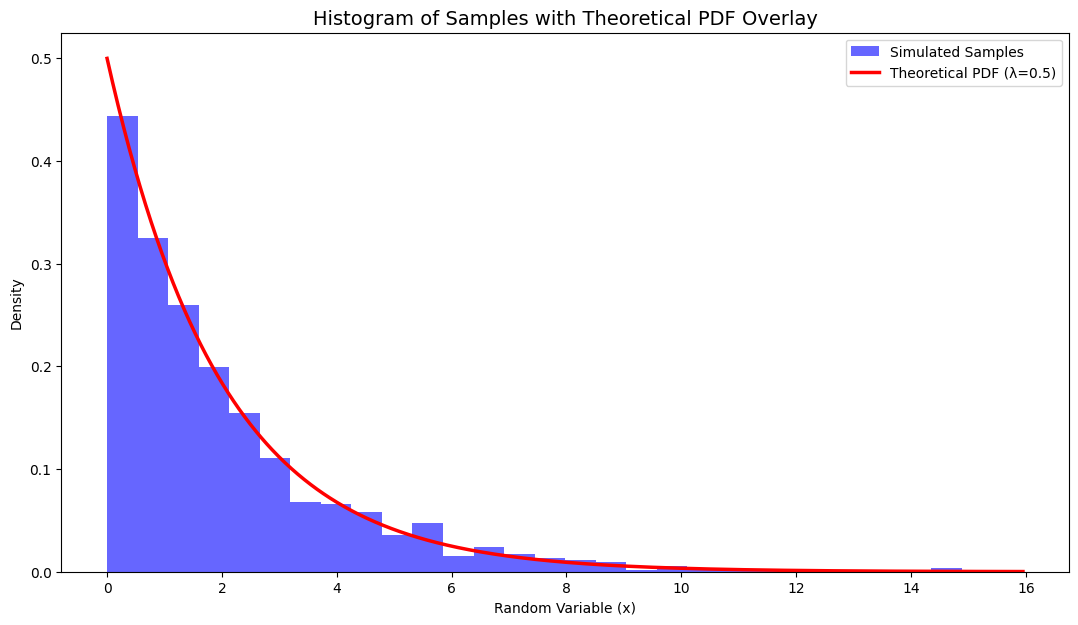

In [151]:
fig, ax = plt.subplots(figsize=(13, 7))
# Plot Histogram
ax.hist(samples, bins=30, density=True, color="blue", alpha=0.6, label="Simulated Samples")

# Overlay Theoretical PDF
ax.plot(x, pdf, color="red", linewidth=2.5, label="Theoretical PDF (λ=0.5)")

ax.set_title("Histogram of Samples with Theoretical PDF Overlay", fontsize=14)
ax.set_xlabel("Random Variable (x)")
ax.set_ylabel("Density")
ax.legend()


#### Q2. (Optional)
#### Theoretical Mean and Variance:  
   Using the formulas from the slide, compute the theoretical mean and variance for an Exponential distribution with λ = 0.5.  


##### Answer
Theoretical mean of exponential distribution is : $ \frac{1}{\lambda} $ 

Theoretical variance of exponential distribution is : $ \frac{1}{\lambda^2} $ 

In [152]:
rpr = 0.5
print("Mean = ",1/rpr)
print("Variance = ",1/rpr**2)

Mean =  2.0
Variance =  4.0


#### Q3. (Optional)
#### Compute Tail Probability:  
   For an Exponential(λ = 0.5) random variable, calculate P[T > 3] using the survival function (i.e. 1 – CDF) as derived in the slide.  
  

##### Answer
CDF of exponential distribution is given by:
$$
F(x) = 
\begin{cases}
0, & \text{if } x \leq 0 \\ 
1-e^{\lambda x}, & \text{if } x>0
\end{cases}
$$ 

$$
P[T>3] = 1 - F[3]
= 1 - (1 - e^{0.5 * 3})
= e^{1.5}
$$

In [153]:
import math
print("P[T>3] = ",round(math.exp(1.5),3))

P[T>3] =  4.482


# 16. **Gaussian Random Variables**

#### Q1. (**Mandatory**)
The PDF of a Gaussian random variable $ X \sim \mathcal{N}(\mu, \sigma^2) $ is given by:

 $$
 f_X(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).
 $$
1. Use `torch.distributions`, generate 100 random samples from a Gaussian distribution with a mean of 3 and a standard deviation of 2.
2. Plot a histogram of the samples and calculate the sample mean and variance of the distribution.
3. Repeat this process for sample sizes of 10000 and 1000000.

Observe how the shape of the histogram changes as the sample size increases. What patterns or trends do you notice in the calculated sample mean and variance?

In [154]:

def hist_plot(N):
    mu = 3
    sigma = 2
    dist4 = torch.distributions.Normal(mu,sigma)
    sample = dist4.sample((N,))
    pd.Series(sample).plot(kind='hist',
        title=f"Normal Distribution Histogram, Sample size = {N}",
        xlabel="Random variable bins",ylabel="Frequency")

sampleRadios = widgets.RadioButtons(options=[100,10000,1000000],
                description="Sample Size")
interact(hist_plot,N=sampleRadios)

interactive(children=(RadioButtons(description='Sample Size', options=(100, 10000, 1000000), value=100), Outpu…

<function __main__.hist_plot(N)>

# Exp

#### Q2. (Optional)
Let $ X \sim \mathcal{N}(0,1) $ be a standard Gaussian random variable. Define a new random
variable $ Y = 4X + 10 $. What is the distribution of $ Y $? Verify your answer by ploting histogram of random variable $Y$. You can use `torch.distributions` for generating samples for Gaussian random vairable.

Answer. The new mean will be 4 * 0 + 10 = 10 and new $\sigma$ will be 4. Thus, new distribution will be distribution of N(10,4). 

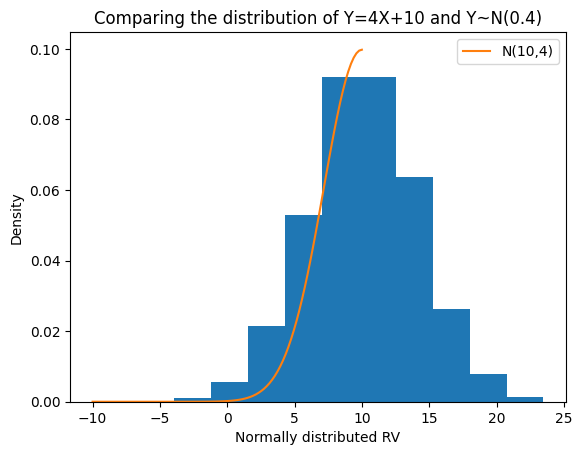

In [155]:
def transform(mu,sigma,size=10000):
    #Generating normal dist
    dist = torch.distributions.Normal(mu,sigma)
    sample = dist.sample((size,)).numpy()
    #Generating transformed sample
    sample2 = 4*sample + 10
    plt.hist(sample2,density=True)
    #Defining PDF func of normal dist
    def n(m,s,x): return np.exp(-((x-m)/s)**2)/np.sqrt(2*(np.pi)*(s**2))
    #Plotting the pdf og N(10,4)
    x = np.linspace(-10,10,100)
    y = n(10,4,x)
    plt.plot(x,y,label='N(10,4)')
    plt.xlabel("Normally distributed RV")
    plt.ylabel("Density")
    plt.title("Comparing the distribution of Y=4X+10 and Y~N(0.4)")
    plt.legend()
transform(0,1)

#### Q3. (Optional)

Let $X \sim \mathcal{N}(\mu_1, \sigma_1^2)$ with $\mu_1 = 3$ and $\sigma_1 = 2$, and let
$Y \sim \mathcal{N}(\mu_2, \sigma_2^2)$ with $\mu_2 = -1$ and $\sigma_2 = 1$. Define a new random variable
$Z = X + Y$.
1. Determine the theoretical mean and variance of Z. Write this in a markdown cell.
2. Verify the theoretical mean and variance that you get by generating 10,000 samples for 𝑋 and 𝑌 using `torch.distributions` and computing their sum to get 𝑍. Print the empirical mean and variance of 𝑍.
3. Plot histogram of the distribution of random variable 𝑍.


Answer:

$$
E[X+Y] = E[X] + E[Y] 
= \mu_1+ \mu_2
= 3 - 1 = 2   
$$

$$
\sigma_Z^{2} = \sigma_1^{2} + \sigma_2^{2} = 4 + 1  = 5

In [156]:
N = 10000
normalDist1 = torch.distributions.Normal(3,2)
sampl1 = normalDist1.sample((N,))
normalDist2 = torch.distributions.Normal(-1,1)
sampl2 = normalDist2.sample((N,))
Z_sample = sampl1 + sampl2
df = pd.DataFrame(Z_sample,columns=["Sample"])
print("Mean of Z is: ",df['Sample'].mean())
print("Variance of Z is: ",df['Sample'].var())

Mean of Z is:  1.9827477
Variance of Z is:  5.109045


<Axes: ylabel='Frequency'>

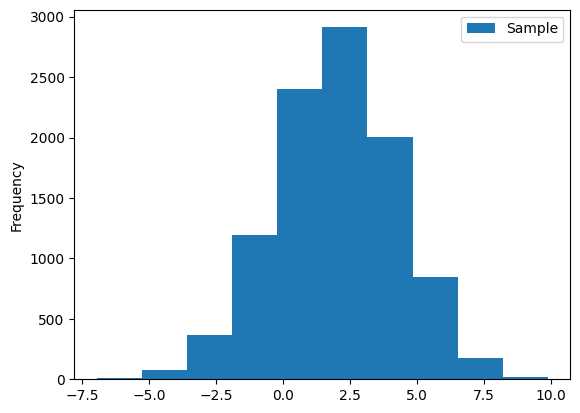

In [157]:
df.plot(kind='hist')

# 17. **Transformation of random Variables**

#### Q1. (**Mandatory**)
Write a function that performs the following tasks:

1. Generate 10,000 samples from a uniform distribution in the range [0, 1].
2. Apply a linear transformation Y = 2X + 3 to the generated samples.
3. Plot the histogram of the original samples and the transformed samples side by side.
4. Calculate and print the mean and variance of both the original and transformed distributions.

In [158]:
#1.
N = 10000
a = 0
b = 5
dist5 = torch.distributions.Uniform(0,5)
uniformSamples = dist5.sample((N,))
pd.DataFrame(uniformSamples,columns=['Samples']).head()

,Samples
0,3.938062
1,1.368353
2,1.076385
3,3.823805
4,3.919361


In [159]:
#2.
M,C = 2,3
uniformSamplesNew = M*uniformSamples + C
pd.DataFrame(uniformSamplesNew,columns=['Samples']).head()

,Samples
0,10.876125
1,5.736707
2,5.152770
3,10.647610
4,10.838721


Text(0.5, 0.98, 'Histogram Plot Original and Transformed Samples')

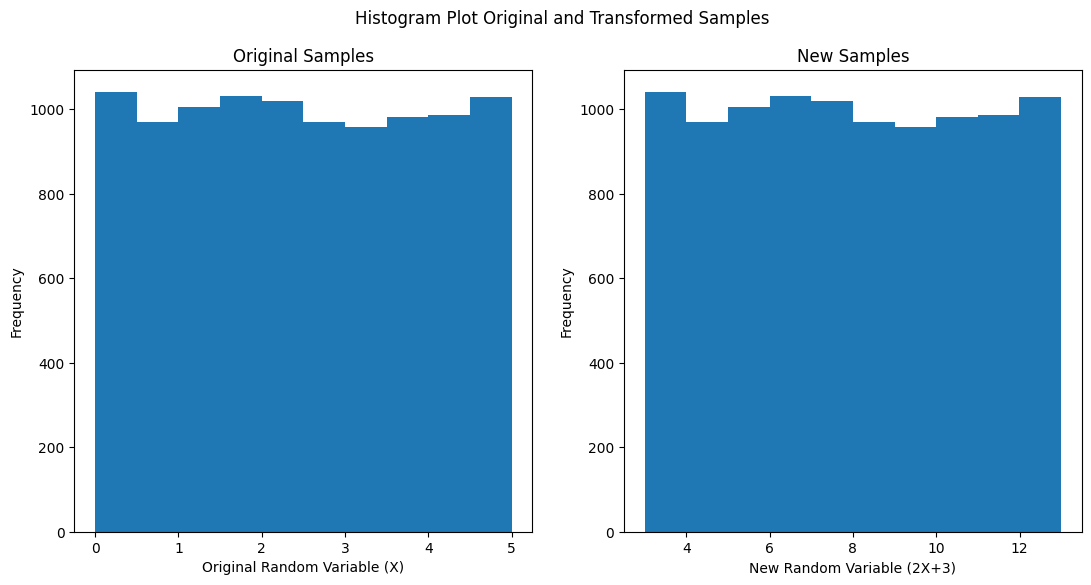

In [160]:
#3.
fig,axes = plt.subplots(1,2,figsize=(13,6))
axes[0].hist(uniformSamples)
axes[0].set_xlabel("Original Random Variable (X)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Original Samples")
axes[1].hist(uniformSamplesNew)
axes[1].set_xlabel("New Random Variable (2X+3)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("New Samples")
fig.suptitle("Histogram Plot Original and Transformed Samples")

In [161]:
#4.
stats = pd.DataFrame(data={
    "Original Data (X)": [round(pd.DataFrame(uniformSamples).mean().item(),3),round(pd.DataFrame(uniformSamples).median().item(),3)]
    ,"Transformed Data (2X+3)": [round(pd.DataFrame(uniformSamplesNew).mean().item(),3),round(pd.DataFrame(uniformSamplesNew).median().item(),3)]
},index=["Mean","Median"])
stats["Theoretical (2X+3)"] = 2*stats['Original Data (X)'] + 3
stats["Deviation"] = stats['Theoretical (2X+3)'] - stats['Transformed Data (2X+3)']
display(stats)

,Original Data (X),Transformed Data (2X+3),Theoretical (2X+3),Deviation
Mean,2.489,7.979,7.978,-0.001
Median,2.466,7.931,7.932,0.001


#### Q2. (Optional)
Let X be a continuous random variable following a Uniform(0,1) distribution. Define a new random variable: Y=−ln(X)

(a). Generate 10,000 samples of **X** and compute **Y**.

(b). Plot the histogram of **Y**, and compare it with the probability density function (PDF) of an exponential distribution with parameter λ=1/2.

<Axes: title={'center': 'Histogram of Y = -ln(X)'}, xlabel='Bins', ylabel='Normalised Frequency'>

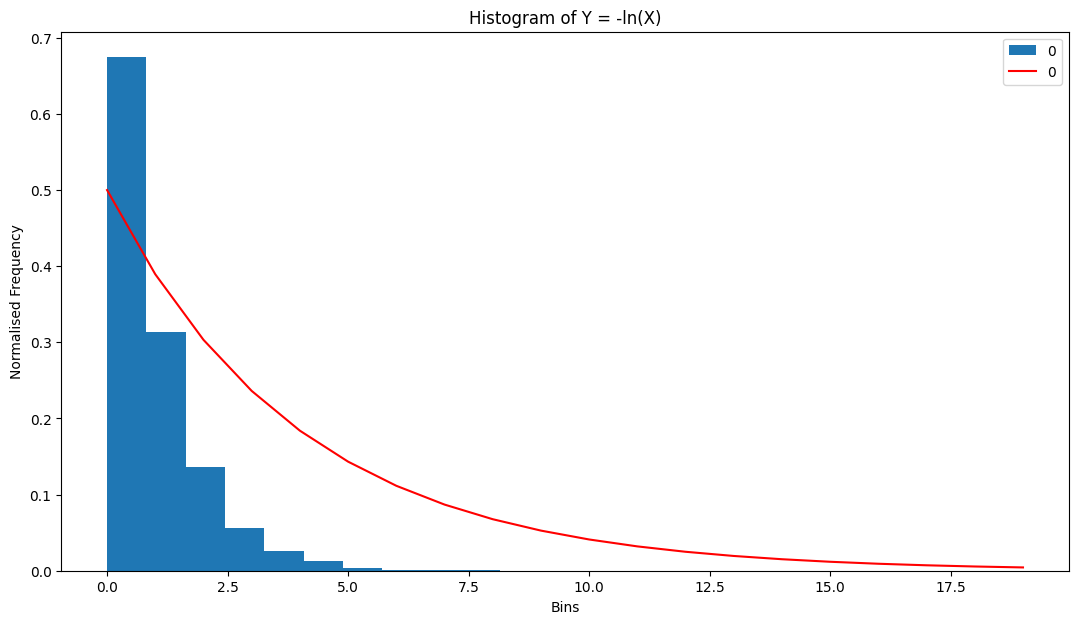

In [162]:
N = 10000
Udist = torch.distributions.Uniform(0,1)
#(a)
X = Udist.sample((N,))
#(b)
Y = -np.log(X)
x = np.arange(0,10,0.5)
E = 0.5*np.exp(-0.5*x)
fig,axes = plt.subplots(figsize=(13,7))
pd.DataFrame(Y).plot(kind='hist',xlabel="Bins",ylabel="Normalised Frequency",density=True,title="Histogram of Y = -ln(X)",ax=axes)
pd.DataFrame(E).plot(kind='line',ax=axes,label="Exponential Distribtion",color="red")

#### Q3. (Optional)
Combined Transformation Involving a Logarithmic Function

Let $X \sim \mathcal{N}(0,1)$ and define a new random variable $Z = \ln(|X| + 1)$.

1. Use `torch.distributions` to simulate 10,000 samples of $X$, compute $Z$, and estimate its empirical distribution.
2. Plot the histogram of $Z$ and compare it with the histogram of $X$.


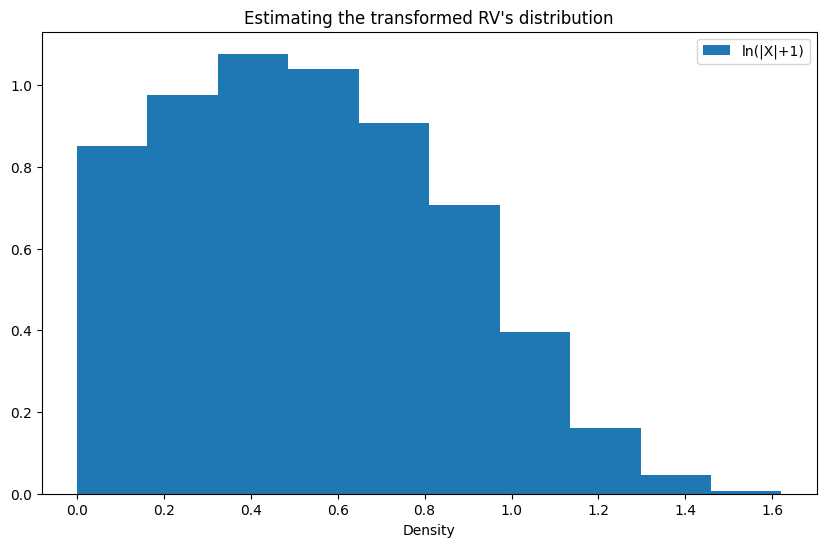

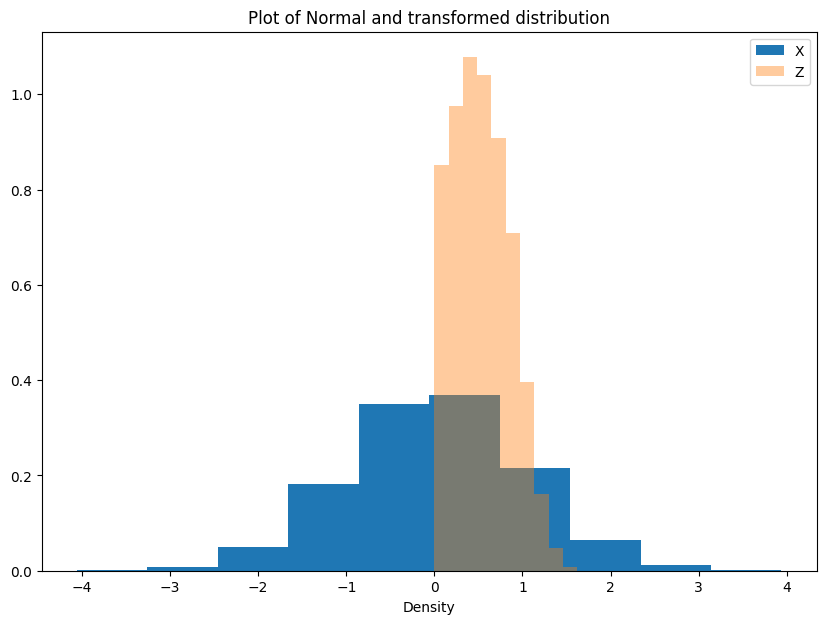

In [163]:
def N(mu,sigma,size=10000):
    dist = torch.distributions.Normal(mu,sigma)
    X = dist.sample((size,)).numpy()
    Z = np.log(np.abs(X)+1)
    #Estimating the empirical distribution by plotting histogram
    fig1,axes1 = plt.subplots(figsize=(10,6))
    axes1.hist(Z,label='ln(|X|+1)',density=True)
    axes1.set_title("Estimating the transformed RV's distribution")
    axes1.set_xlabel("Continuous RV")
    axes1.set_xlabel("Density")
    axes1.legend()
    #Plotting the histogram of Z and comparing it with histogram of X
    fig,axes = plt.subplots(figsize=(10,7))
    axes.hist(X,density=True,label='X')
    axes.hist(Z,density=True,label='Z',alpha=0.4)
    axes.set_xlabel("Continuous RV")
    axes.set_xlabel("Density")
    axes.set_title("Plot of Normal and transformed distribution")
    axes.legend()
    
N(0,1)
    

# 18. **Generating Random Numbers**

#### Q1. (**Mandatory**)

(a) Generate 10,000 samples from a uniform distribution U(0,1).

(b) Transform these samples to generate exponential random variables with parameter λ = 2.

(c) Plot a histogram of the generated exponential random variables.

In [164]:
#(a)
N = 10000
dist6 = torch.distributions.Uniform(0,1)
U = dist6.sample((N,))
pd.DataFrame(U,columns=["Samples"]).head()

,Samples
0,0.118642
1,0.139713
2,0.866735
3,0.209978
4,0.225985


##### Part (b) Calculation
<br> To tranform uniform random variable to exponential random variable we use the inverse transform method. In this method, we equate U to CDF of exponential distribution.

Let U ~ Uniform(0,1).Then, the Uniform distribution is given by:

$$
F[X] =
\begin{cases}
\frac{1}{1-0}, & \text{if } 0 \leq x \leq 1 \\
0, & \text{otherwise} 
\end{cases}
$$
Let X ~ Exponential($ \lambda $), where $ \lambda = 2 $ is the rate paramter. It's PDF is:
$$
F_E[X] = \lambda e^{-\lambda x}
$$

The CDF of exponential distribution is: $$ F_E[X \leq x] = 1 - e^{-\lambda x} $$

Equating U to CDF of exponential distribution: $$ U = 1 - e^{-\lambda X} $$
<br> On Solving for X, we get, </br> 

$$ X = \frac{1}{\lambda} \ln{\frac{1}{1-U}} $$
Thus we will use the above transformation to transform the samples Uniform to exponential distribution

In [165]:
#Part (b) Code
expDistParam = 2
X = (1/expDistParam)*np.log(1/(1-U))
pd.DataFrame(X,columns=["Samples"]).head()

,Samples
0,0.063146
1,0.075244
2,1.007706
3,0.117847
4,0.128082


Text(0.5, 0.98, 'Transforming the Samples from Uniform to Exponential Distribution')

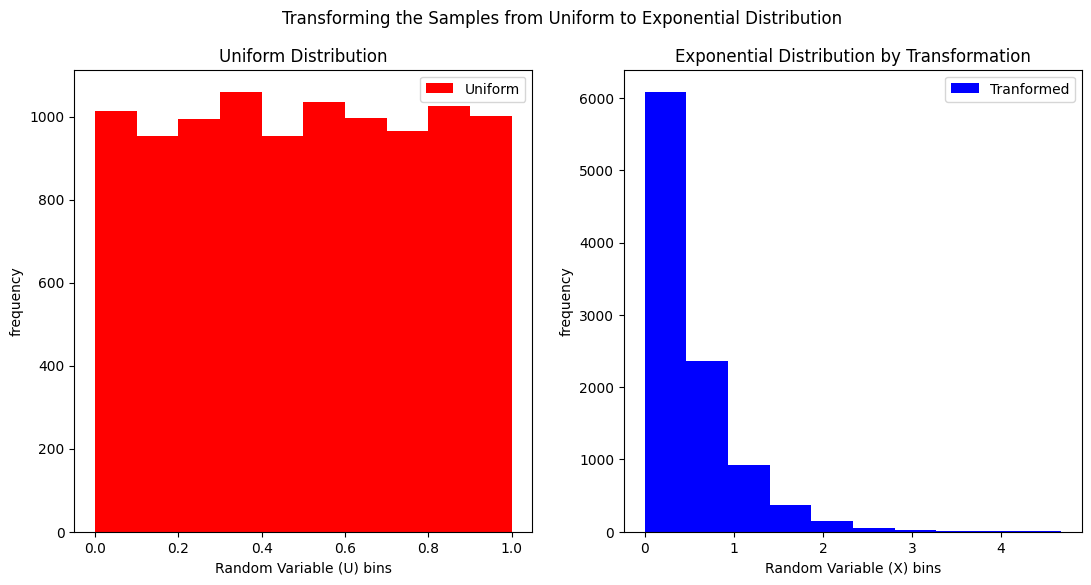

In [166]:
#Part (c) Plotting the histogram of X
fig,axes = plt.subplots(1,2,figsize=(13,6))
axes[0].hist(U,color='red',label="Uniform")
axes[0].set_title("Uniform Distribution")
axes[0].set_xlabel("Random Variable (U) bins")
axes[0].set_ylabel("frequency")
axes[0].legend()
axes[1].hist(X,color='blue',label="Tranformed")
axes[1].set_title("Exponential Distribution by Transformation")
axes[1].set_xlabel("Random Variable (X) bins")
axes[1].set_ylabel("frequency")
axes[1].legend()
fig.suptitle("Transforming the Samples from Uniform to Exponential Distribution")

#### Q2. (Optional)
Given an exponential distribution with rate parameter λ=3.

write a Python function that:

(a) Generates a single exponential random variable using inverse transform sampling.
Uses the transformation X=− 1/λ ln(1−U), where U is a uniform random number between 0 and 1 and returns the generated exponential random variable.

In [167]:
def inverse_transform(U,lmbda):
    return (-1/lmbda)*np.log(1-U)
uDist = torch.distributions.Uniform(0,1)
U = uDist.sample((N,))
X = inverse_transform(U,3)
both_samples = pd.DataFrame(data={
    "Samples of Uniform": U,
    "Samples of Transformed": X
})
both_samples.head(10)

,Samples of Uniform,Samples of Transformed
0,0.937521,0.924306
1,0.086550,0.030176
2,0.374544,0.156425
3,0.790949,0.521726
4,0.517429,0.242876
5,0.113665,0.040220
6,0.200150,0.074444
7,0.209281,0.078271
8,0.940983,0.943309
9,0.818159,0.568208


#### Q3. (Optional)
 Write a Python function that:

(a). Generates N random samples from a uniform distribution U(0,1) and transforms the samples into exponential random variables with rate λ=5 using inverse transform sampling.

(b) Apply a nonlinear transformation Z = X² to each generated exponential random variable X.

(c) Calculates and returns the following:

    (a) The proportion of values in Z that exceed a threshold t (provided as a function parameter).

    (b) The sample mean and sample variance of both X and Z.

In [168]:
N = 1000
def func(N,t):
    #(a)
    uDist2 = torch.distributions.Uniform(0,1)
    lmbda = 5
    U = uDist2.sample((N,))
    X = inverse_transform(U,lmbda)
    #(b) Applying Non linear transform
    Z = X**2
    #(c)(a)
    Z_dummy = pd.DataFrame(Z,columns=['Samples'])
    X_dummy = pd.DataFrame(X,columns=['Samples'])
    portion = Z_dummy[Z_dummy['Samples'] > t].copy()
    #(c)(b)
    stats = pd.DataFrame(data={
        "X": [X_dummy.mean().item(),X_dummy.var().item()],   
        "Z": [Z_dummy.mean().item(),Z_dummy.var().item()]   
    },index=["Mean","Variance"])
    return portion,stats
tSlider = widgets.IntSlider(min=0,max=10,step=0.01,description="t parameter")
Nradio = widgets.RadioButtons(options=[1000,10000,1000000],description="t parameter")
def performer(N,t):
    portion,stats = func(N,t)
    display(f"Portion above {t} in Z is: ",portion)
    display(f"Stats of X and Z are: ",stats)
interact(performer,N=Nradio,t=tSlider)

interactive(children=(RadioButtons(description='t parameter', options=(1000, 10000, 1000000), value=1000), Int…

<function __main__.performer(N, t)>